Troy Mazerolle

Student Number 8972394

# Lab 9 - Dense Neural Network

In [1]:
# Utility Libraries
import numpy as np
import pandas as pd

# # Plotting Libraries
import matplotlib.pyplot as plt

# # sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tensorflow
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense

# Set seed for reproducability
keras.utils.set_random_seed(8972394)

## 1. Using Keras Datasets, obtain the fMNIST data set. Explore and describe it as you would do with any new dataset that you start working with.

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

First, let's look at the structure of the data.  I would like to see how many training and testing observations we have, as well as the categories we have in the target label.

In [3]:
categories = np.unique(y_train)
print("Shape of training features:", X_train.shape)
print("Shape of training targets:", y_train.shape)
print("Shape of testing features:", X_test.shape)
print("Shape of testing targets:", y_test.shape)
print("Target categories:", categories)

Shape of training features: (60000, 28, 28)
Shape of training targets: (60000,)
Shape of testing features: (10000, 28, 28)
Shape of testing targets: (10000,)
Target categories: [0 1 2 3 4 5 6 7 8 9]


Our training data consists of 60,000 28*28 matricies representing images, and our testing data contains another 10,000.  The target variable contains ten unique categories, labeled from 0 to 9.  From the fashion_mnist.load data documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data), we know what each label corresponds to.  We will create a dictionary to map the values to their label name since it will be useful to evaluate errors in the last part.

In [4]:
display_labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 
                  4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 
                  8: "Bag", 9: "Ankle boot"}
category_labels = np.vectorize(lambda x: display_labels[x])(categories)

I also want to get a sense of what our images look like.  To do this, we will graph the first instance of each target.

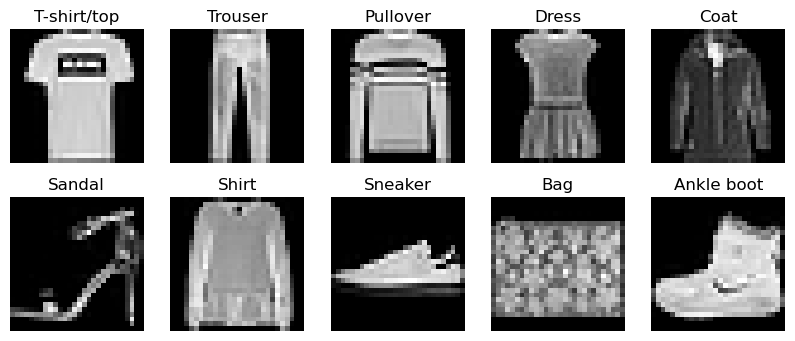

In [5]:
plt.figure(figsize=(10, 4))
y_train_aslist = y_train.tolist()
for i in range(len(categories)):
    plt.subplot(2, 5, i + 1)
    first_index = y_train_aslist.index(categories[i])
    plt.imshow(X_train[first_index].reshape(28, 28), cmap = 'gray')
    plt.title(category_labels[y_train[first_index]])
    plt.axis('off')
plt.show()

## 2. Train a dense neural network using Keras, try out at least three hyperparameters configurations

First we need to transform the data.  The feature arrays need to be transformed into 2-D arrays that contain 60,000 rows of 784 (28*28) features.  The features also need to be normalized to be between 0 and 1.  To (crudely) show that the values have been normalized, we will output the sum of matrix elements before and after the normalization.

In [6]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]).astype("float32")
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]).astype("float32")
print("Shape of training features:", X_train.shape)
print("Shape of testing features:", X_test.shape)

print("Sum of training elements before normalization:", sum(sum(X_train)))
X_train = X_train / 255.0
print("Sum of training elements after normalization:", sum(sum(X_train)))

print("Sum of testing elements before normalization:", sum(sum(X_test)))
X_test = X_test / 255.0
print("Sum of training elements after normalization:", sum(sum(X_test)))

Shape of training features: (60000, 784)
Shape of testing features: (10000, 784)
Sum of training elements before normalization: 3431114169.0
Sum of training elements after normalization: 13455973.118989483
Sum of testing elements before normalization: 573469082.0
Sum of training elements after normalization: 2248891.7327095307


Since the sum of elements in the training and testing sets shrunk by a factor of about 255, so the normalization was successful.  We can also see that the training and testing features have 60,000 rows and 784 columns, so transforming the data into a 2-D array was also successful.

We now move on to training the model.  The assignment wants us to test a few different hyperparameters and choose the best one.  However, I thought this would be a good time to test a function I wrote to test multiple combinations of hyperparameters and yield the best accuracy.

In [7]:
def neural_network_optimizer(x, y, x_val, y_val, batches, nodes, layers, activation_list = ["relu"], epochs = [10], output_activation_function = "softmax", 
                             optimizer = "adam", loss_function = "sparse_categorical_crossentropy", accuracy_metrics = ["accuracy"], verbose = True):
    """
    Limitations:
    * Only dense layers are implemented.
    * "adam" is the only optimizer used at this moment. However, it will not be difficult 
      to add more; it would just be an extra for loop going over different optimizers.
    * "softmax" is the only output activation function being tested since the function 
      was originally designed to perform multiclass classification.
    * "sparse_categorical_crossentropy" is the only loss function being tested since the 
      function was originally designed to perform multiclass classification.
    """

    categories = np.unique(y)

    batch_count = []
    node_count = []
    epoch_count = []
    activation_function = []
    layer_count = []
    accuracy = []

    for actfunc_index in range(len(activation_list)):
        for batch_index in range(len(batches)):
            for node_index in range(len(nodes)):
                for layer_index in range(len(layers)):
                    for epoch_index in range(len(epochs)):
                        
                        # Initializing model
                        dense_nn = keras.Sequential()

                        # Adding first layer
                        dense_nn.add(Dense(nodes[node_index], activation = activation_list[actfunc_index], input_shape = (x.shape[1],)))

                        # Adding more layers
                        for num_layers in range(layers[layer_index] - 1):
                            dense_nn.add(Dense(nodes[node_index], activation = activation_list[actfunc_index]))
                            
                        # Adding output layer
                        dense_nn.add(Dense(len(categories), activation = output_activation_function))

                        # Compiling neural network
                        dense_nn.compile(optimizer = optimizer, loss = loss_function, metrics = accuracy_metrics)

                        # Training the model
                        fitted_nn = dense_nn.fit(x, y, batch_size = batches[batch_index], epochs = epochs[epoch_index], 
                                                 validation_data = (x_val, y_val), verbose = 0)

                        activation_function.append(activation_list[actfunc_index])
                        batch_count.append(batches[batch_index])
                        node_count.append(nodes[node_index])
                        layer_count.append(layers[layer_index])
                        epoch_count.append(epochs[epoch_index])
                        accuracy.append(fitted_nn.history["val_accuracy"][len(fitted_nn.history["val_accuracy"]) - 1])

                        if verbose:
                            print("Activation Function Used:", activation_list[actfunc_index], ",", actfunc_index + 1, "/", len(activation_list), "complete")
                            print("Batches Used:", batches[batch_index], ",", batch_index + 1, "/", len(batches), "complete")
                            print("Nodes Used:", nodes[node_index], ",", node_index + 1, "/", len(nodes), "complete")
                            print("Layers Used:", layers[layer_index], ",", layer_index + 1, "/", len(layers), "complete")
                            print("Epochs Used:", epochs[epoch_index], ",", epoch_index + 1, "/", len(epochs), "complete")
                            print("Accuracy:", fitted_nn.history["val_accuracy"][len(fitted_nn.history["val_accuracy"]) - 1])
                            print()

    results = pd.DataFrame()
    results["ActivationFunction"] = activation_function
    results["Layers"] = layer_count
    results["Batches"] = batch_count
    results["Nodes"] = node_count
    results["Epochs"] = epoch_count
    results["Accuracy"] = accuracy
    return results

Using the above function, we will create a few lists of hyperparameters to test.  The function will output the results of all tests, and we can use the combination of hyperparameters that yields the highest accuracy on the test set.

In [8]:
batches = [500, 1000, 1500]
nodes = [1000, 1500, 2000]
layers = [1, 2, 3]
activation_list = ["linear", "relu", "sigmoid"]
epochs = [10, 15, 20]

nn_results = neural_network_optimizer(x = X_train, y = y_train, x_val = X_test, y_val = y_test, batches = batches, 
                                      nodes = nodes, layers = layers, activation_list = activation_list, epochs = epochs, verbose = False)

Now that we have our table of hyperparameters and corresponding accuracies, we select the hyperparameters that give the highest accuracy.

In [9]:
best_model_index = nn_results["Accuracy"].argmax()
best_model = nn_results.iloc[best_model_index]
print(best_model)

ActivationFunction      relu
Layers                     2
Batches                 1000
Nodes                   1500
Epochs                    20
Accuracy              0.8983
Name: 122, dtype: object


It is worth noting that for more precise results, k-fold cross-validation should be used.  This could potentially be done by splitting the data into k sections, looping this function k times and averaging the accuracy scores.

Now that we have the hyperparameters that yield the highest accuracy on the test set, we can use them to build the main model.

In [10]:
# Defining Optimal Parameters
actfunc_opt = best_model["ActivationFunction"]
batch_opt = best_model["Batches"]
node_opt = best_model["Nodes"]
epoch_opt = best_model["Epochs"]

# Initializing model
dense_nn = keras.Sequential()

# Adding layers (note that we should have three extra layers, not including the output layer)
dense_nn.add(Dense(node_opt, activation = actfunc_opt, input_shape = (X_train.shape[1],)))
dense_nn.add(Dense(node_opt, activation = actfunc_opt))
dense_nn.add(Dense(node_opt, activation = actfunc_opt))
dense_nn.add(Dense(len(categories), activation = "softmax"))

# Compiling neural network
dense_nn.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
# dense_nn.summary()

# Training the model
fitted_nn = dense_nn.fit(X_train, y_train, epochs = epoch_opt, batch_size = batch_opt, validation_data = (X_test, y_test))

Epoch 1/20
60/60 [==============================] - 1s 8ms/step - loss: 0.6623 - accuracy: 0.7651 - val_loss: 0.4171 - val_accuracy: 0.8489
Epoch 2/20
60/60 [==============================] - 0s 7ms/step - loss: 0.3655 - accuracy: 0.8670 - val_loss: 0.3670 - val_accuracy: 0.8670
Epoch 3/20
60/60 [==============================] - 0s 7ms/step - loss: 0.3164 - accuracy: 0.8837 - val_loss: 0.3461 - val_accuracy: 0.8771
Epoch 4/20
60/60 [==============================] - 0s 7ms/step - loss: 0.2933 - accuracy: 0.8905 - val_loss: 0.3405 - val_accuracy: 0.8762
Epoch 5/20
60/60 [==============================] - 0s 7ms/step - loss: 0.2657 - accuracy: 0.9002 - val_loss: 0.3181 - val_accuracy: 0.8865
Epoch 6/20
60/60 [==============================] - 0s 7ms/step - loss: 0.2531 - accuracy: 0.9048 - val_loss: 0.3192 - val_accuracy: 0.8852
Epoch 7/20
60/60 [==============================] - 0s 7ms/step - loss: 0.2324 - accuracy: 0.9133 - val_loss: 0.3195 - val_accuracy: 0.8853
Epoch 8/20
60/60 [==

Lastly, we will generate a set of predictions and test them against their actual values.

In [11]:
y_pred_matrix = dense_nn.predict(X_test)
print("Percent classificaiton of each target category:")
print(y_pred_matrix[:5])

313/313 [==============================] - 0s 727us/step
Percent classificaiton of each target category:
[[2.05800030e-10 2.69528915e-08 1.88124363e-10 2.04745754e-09
  1.50199020e-11 6.93329048e-06 1.07977227e-09 1.12062531e-04
  5.34840439e-09 9.99880910e-01]
 [2.76567043e-05 7.99458832e-10 9.99010801e-01 6.28782644e-08
  9.46553191e-04 8.58625504e-10 1.48635900e-05 8.99215355e-11
  8.73492390e-09 7.45889600e-11]
 [5.93009941e-22 1.00000000e+00 6.76431648e-26 1.08365106e-18
  1.03666784e-21 1.83350919e-30 1.10474973e-19 6.72142121e-31
  1.28349426e-26 2.05687084e-26]
 [9.01271904e-19 1.00000000e+00 3.85112781e-22 1.67262664e-14
  6.40383636e-19 1.41528475e-25 5.36815237e-17 5.89658658e-27
  2.81380595e-23 1.66853813e-22]
 [3.98531139e-01 1.60219798e-07 2.01793783e-03 5.11062506e-04
  2.69856042e-04 6.69663166e-07 5.98664403e-01 8.14617138e-08
  4.55804593e-06 1.56575496e-07]]


The model will evaluate the percent chance that the observation belongs to each category.  We can take the target with the highest percent chance and make that the prediction.

In [12]:
y_pred = np.argmax(y_pred_matrix, axis = 1)
print("Predicted values:", y_pred)

Predicted values: [9 2 1 ... 8 1 5]


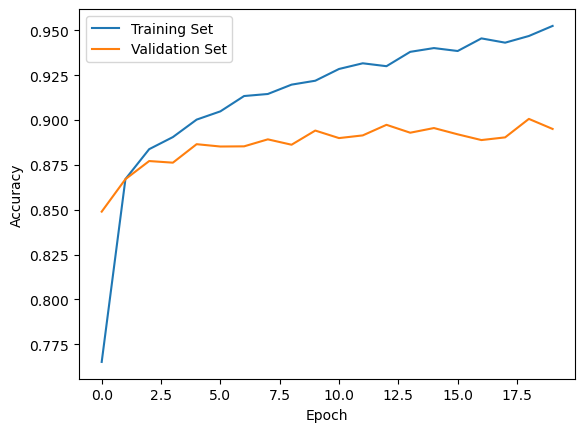

In [13]:
plt.plot(fitted_nn.history["accuracy"])
plt.plot(fitted_nn.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Validation Set"]);

## 3. Evaluate its accuracy. Report accuracy, confusion metric, explore specific examples of incorrect classification, and drew some conclusions from this exploration.

We start by looking at the total accuracy of the model and the confusion matrix.

Total accuracy: 0.895


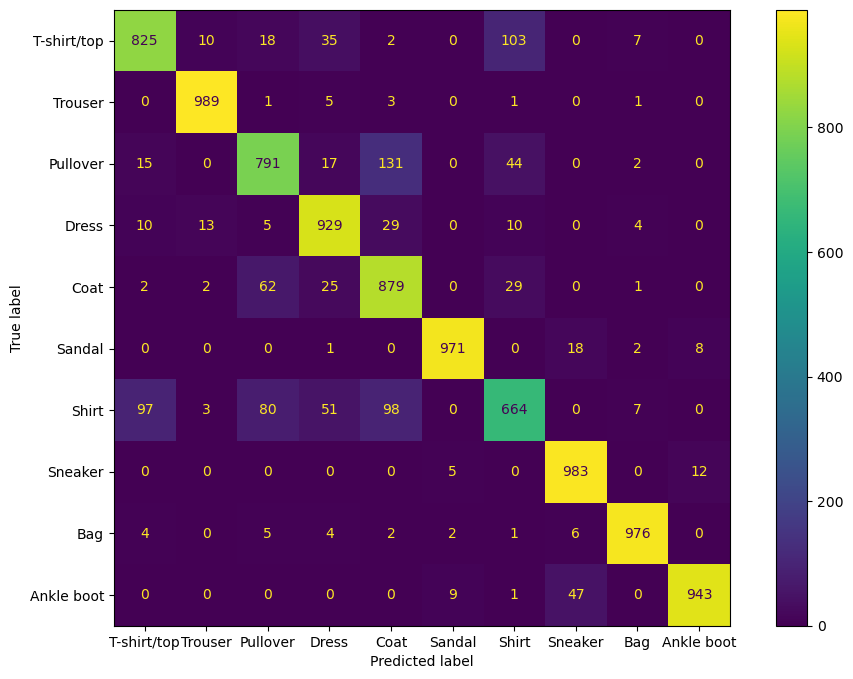

In [14]:
print("Total accuracy:", sum(y_test == y_pred) / len(y_test))

fig, ax = plt.subplots(figsize=(12,8))
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = category_labels).plot(ax = ax);

Our model has about 90% accuracy on the test set.

Our confusion matrix seems strong, but there is a noticable amount of misclassifications around `T-shirt/top`, `Pullover`, `Coat`, and `Shirt` between each other.  We can go back and examine the percent chance that These categories had to be classified with each other.

In [15]:
misclass_filter = (~(y_test == y_pred)).astype(bool)

shirt_filter = np.zeros(len(y_test)).astype(int)
for i in range(len(shirt_filter)):
    if y_test[i] == 0 or y_test[i] == 2 or y_test[i] == 4 or y_test[i] == 6:
        shirt_filter[i] = 1
shirt_filter = shirt_filter.astype(bool)

shirt_misclass_filter = np.logical_and(shirt_filter, misclass_filter)
shirt_misclasses = y_pred_matrix[shirt_misclass_filter, :7:2] # columns kept with :7:2 correspond to 0, 2, 4, 6 which are the shirt variant columns

# Print first 10 rows
print("Percent classifications of T-shirt/top, Pullover, Coat, and Shirt:")
for i in range(10):
    print(shirt_misclasses[i])

Percent classifications of T-shirt/top, Pullover, Coat, and Shirt:
[2.3582395e-06 9.5905715e-01 4.0586594e-02 3.5387225e-04]
[9.7050238e-01 2.2612192e-05 5.8167802e-06 2.9467329e-02]
[2.0987211e-05 9.4640774e-01 5.0721463e-02 2.8450817e-03]
[0.12007505 0.15139598 0.01276357 0.5562813 ]
[9.2763767e-06 2.9660994e-01 7.0336908e-01 7.6888828e-06]
[0.05834796 0.8482651  0.00145841 0.09143368]
[0.06024463 0.06307817 0.6608251  0.1754427 ]
[2.8282549e-05 2.9567422e-02 8.0692226e-01 1.6346145e-01]
[3.5629648e-01 1.9834653e-02 2.0051359e-04 9.0883756e-03]
[0.00105828 0.0012109  0.21891668 0.00293709]


In some cases earlier, we saw classified targets have a probability as high as over 99.99% and as low as the 10e-30 range.  However, this is not the case for the probabilities above.  The above matrix are the t-shirts, pullovers, coats, and shirts that were misclassified as each other.  We can see from the above that each row of probabilities are a lot closer to each other, and it is not as easy to distinguish the "clear" correct target with extremely high probability against the "clear" wrong targets with extremely low probabilities.

I am also personally curious about some of the uncommon misclassifications.  For example, there was one instance where an ankle boot was misclassified as a shirt.  I would like to see the plot of the ankle boot.  To find the correct image data, I need the index that corresponds to $y\_test == 9$ and $y\_pred == 6$.

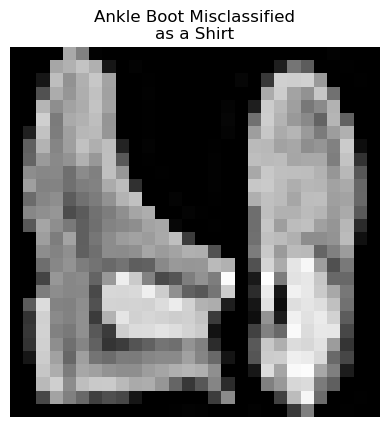

In [16]:
ankle_boot_filter = y_test == 9
dress_filter = y_pred == 6
boot_dress_misclass = np.logical_and(ankle_boot_filter, dress_filter)

plt.imshow(X_test[boot_dress_misclass].reshape(28, 28), cmap = 'gray')
plt.title("Ankle Boot Misclassified\nas a Shirt")
plt.axis('off');

The ankle boot image is actually two ankle boots that vaguely resembles a shirt.  It makes sense that this image was misclassified as a shirt.